### Yelp Dataset 10Mar2025 Validations or Proof of Concepts
#### 1. Extrat Tar File

In [1]:
#! pip install geopandas

In [2]:
from src import modules as f
%load_ext autoreload
%autoreload 2

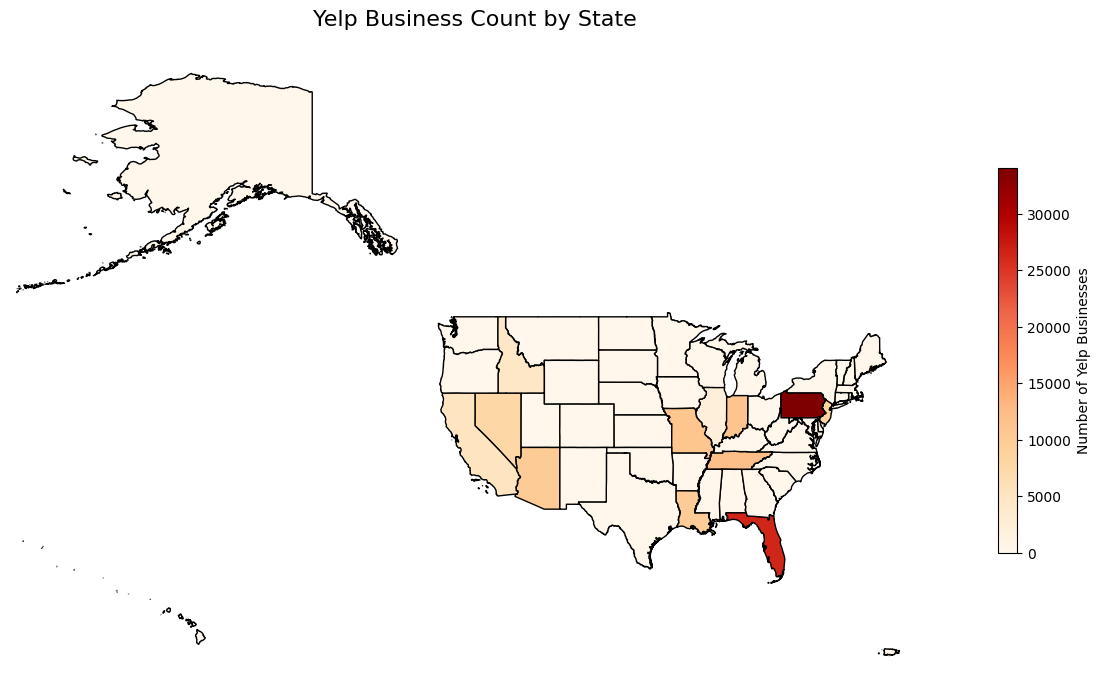

In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Mapping: state abbreviation to full name
us_state_abbrev_to_name = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas',
    'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware',
    'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho',
    'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
    'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
    'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada',
    'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York',
    'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
    'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah',
    'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia',
    'WI': 'Wisconsin', 'WY': 'Wyoming', 'DC': 'District of Columbia'
}

# Load business data
business_df = pd.read_parquet("./data/business.parquet")
state_counts = business_df.groupby("state").size().reset_index(name="business_count")
state_counts["state"] = state_counts["state"].str.upper()
state_counts["state_name"] = state_counts["state"].map(us_state_abbrev_to_name)

# Load GeoJSON
us_states_url = "https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json"
us_states = gpd.read_file(us_states_url)

# Merge using full state names
merged = us_states.merge(state_counts, left_on="NAME", right_on="state_name", how="left")
merged["business_count"] = merged["business_count"].fillna(0).astype(int)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged.plot(
    column="business_count",
    ax=ax,
    legend=True,
    cmap="OrRd",
    edgecolor="black",
    legend_kwds={'label': "Number of Yelp Businesses", 'shrink': 0.5}
)
ax.set_title("Yelp Business Count by State", fontsize=16)
ax.set_xlim([-180, -60])  # include AK
ax.set_ylim([15, 75])     # include HI
plt.axis("off")
plt.show()



In [7]:
print("Sample Yelp states:", state_counts['state'].unique())

Sample Yelp states: ['AB' 'AZ' 'CA' 'CO' 'DE' 'FL' 'HI' 'ID' 'IL' 'IN' 'LA' 'MA' 'MI' 'MO'
 'MT' 'NC' 'NJ' 'NV' 'PA' 'SD' 'TN' 'TX' 'UT' 'VI' 'VT' 'WA' 'XMS']


In [9]:
import pandas as pd

# Load all necessary data
review_df = pd.read_parquet("./data/review.parquet")
checkin_df = pd.read_parquet("./data/checkin.parquet")
tip_df = pd.read_parquet("./data/tip.parquet")
photo_df = pd.read_parquet("./data/photo.parquet")

# --- Aggregations ---
# Unique users per business (from review and tip)
users_from_reviews = review_df.groupby("business_id")["user_id"].nunique()
users_from_tips = tip_df.groupby("business_id")["user_id"].nunique()

# Combine both sources of users
total_users = users_from_reviews.add(users_from_tips, fill_value=0).astype(int)

# Total reviews
total_reviews = review_df.groupby("business_id").size()

# Total checkins (count timestamps)
checkin_df["checkin_count"] = checkin_df["date"].str.split(",").apply(len)
total_checkins = checkin_df.groupby("business_id")["checkin_count"].sum()

# Total tips
total_tips = tip_df.groupby("business_id").size()

# Total photos
total_photos = photo_df.groupby("business_id").size()

# --- Combine all metrics ---
agg_df = pd.DataFrame({
    "total_users": total_users,
    "total_reviews": total_reviews,
    "total_checkins": total_checkins,
    "total_tips": total_tips,
    "total_photos": total_photos
}).fillna(0).astype(int)

agg_df.reset_index(inplace=True)  # make business_id a column

# Display
from IPython.display import display
display(agg_df.head())


,business_id,total_users,total_reviews,total_checkins,total_tips,total_photos
0,---kPU91CF4Lq2-WlRu9Lw,27,24,11,4,0
1,--0iUa4sNDFiZFrAdIWhZQ,19,14,10,6,0
2,--30_8IhuyMHbSOcNWd6DQ,10,9,2,1,0
3,--7PUidqRWpRSpXebiyxTg,15,12,10,3,0
4,--7jw19RH9JKXgFohspgQw,13,13,26,0,0


In [ ]:
# load for the first time to set up files
f.json_2_parquet()

In [ ]:
import os
from pyspark.sql import SparkSession

# Set the correct network IP if necessary
os.environ["SPARK_LOCAL_IP"] = "192.168.5.29"  # or "192.168.5.29" if explicitly needed

# Build Spark session WITHOUT RAPIDS
spark = SparkSession.builder \
    .appName("SparkNoGPU") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to reduce verbosity
spark.sparkContext.setLogLevel("ERROR")

print("Spark session created!")


#### 2. Import JSON Tables

In [ ]:
# Load each Parquet file into a Spark DataFrame
business_df = spark.read.parquet(os.path.join(parquet_dir, 'business.parquet')).sample(False, 0.1, seed=42)
# review_df   = spark.read.parquet(os.path.join(parquet_dir, 'review.parquet')).sample(False, 0.1, seed=42)
# checkin_df  = spark.read.parquet(os.path.join(parquet_dir, 'checkin.parquet')).sample(False, 0.1, seed=42)
# tip_df      = spark.read.parquet(os.path.join(parquet_dir, 'tip.parquet')).sample(False, 0.1, seed=42)
# user_df     = spark.read.parquet(os.path.join(parquet_dir, 'user.parquet')).sample(False, 0.1, seed=42)

# Show a sample from one DataFrame
business_df.show(5)

In [ ]:
spark.stop()